# Project 3: Recommender Systems

Wenxin Cheng	706070535    wenxin0319@g.ucla.edu

Yuxin Yin		606073780    yyxyy999@g.ucla.edu

Yingqian Zhao	306071513    zhaoyq99@g.ucla.edu

### 0 pre-install packages

In [1]:
# !conda install -c conda-forge scikit-surprise

### Question 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from tqdm import tqdm, trange

In [3]:
ratings = pd.read_csv("Synthetic_Movie_Lens/ratings.csv")
movies = pd.read_csv("Synthetic_Movie_Lens/movies.csv")
tags = pd.read_csv("Synthetic_Movie_Lens/tags.csv")
links = pd.read_csv("Synthetic_Movie_Lens/links.csv")

In [4]:
# constructing ratings matrix
R = ratings.pivot_table(values ='rating', index ="userId", columns ='movieId')
num_users, num_movies = R.shape
print(R.shape)
R.head()

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
num_possible_ratings = num_users * num_movies
num_available_ratings = len(ratings)
sparsity = num_available_ratings / num_possible_ratings
print("1A answer: Sparsity = {}".format(sparsity))

1A answer: Sparsity = 0.016999683055613623


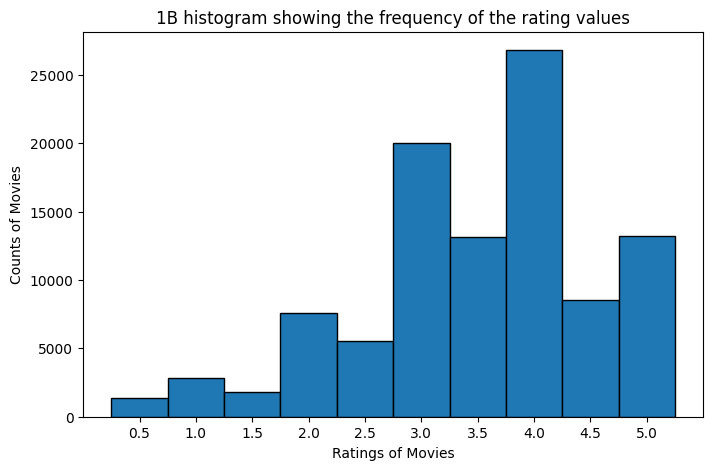

In [6]:
unique_ratings, unique_counts = np.unique(ratings["rating"].values, return_counts=True)

plt.subplots(figsize=(8,5))
plt.bar(unique_ratings, unique_counts, width=0.5, edgecolor='black', linewidth=1)
plt.title("1B histogram showing the frequency of the rating values")
plt.xlabel("Ratings of Movies")
plt.ylabel("Counts of Movies")
plt.xticks(unique_ratings)
plt.show()

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
4093        1
4089        1
58351       1
4083        1
193609      1
Length: 9724, dtype: int64


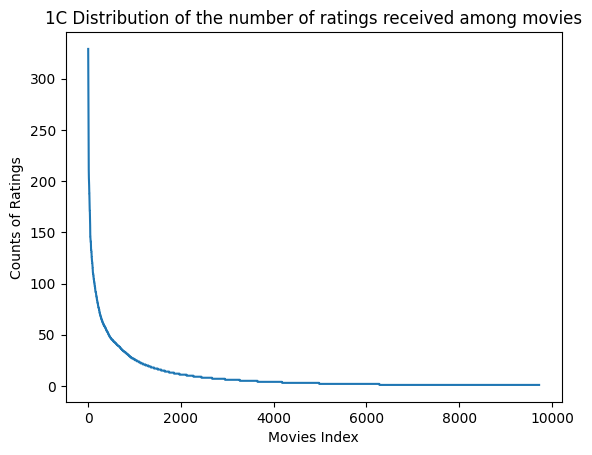

In [7]:
movie_value = (num_users- np.isnan(R).sum()).sort_values(ascending=False)
print(movie_value)
plt.plot(movie_value.values)
plt.title("1C Distribution of the number of ratings received among movies")
plt.xlabel("Movies Index")
plt.ylabel("Counts of Ratings")
plt.show()

In [8]:
print(R.T.shape)

(9724, 610)


userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Length: 610, dtype: int64


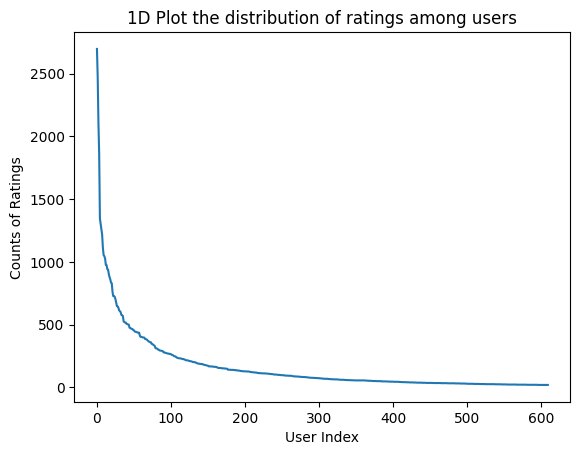

In [9]:
user_value = (num_movies- np.isnan(R.T).sum()).sort_values(ascending=False)
print(user_value)
plt.plot(user_value.values)
plt.title("1D Plot the distribution of ratings among users")
plt.xlabel("User Index")
plt.ylabel("Counts of Ratings")
plt.show()

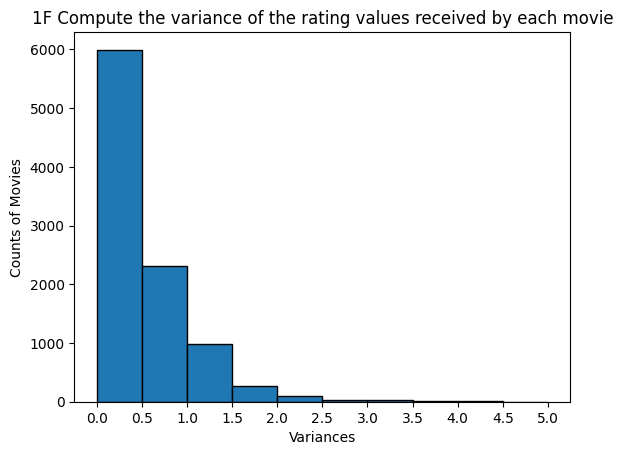

In [10]:
rates = np.linspace(0,5,num=11)
plt.hist(np.var(ratings.pivot_table("rating", "userId", "movieId")).values,bins=rates,edgecolor='black', linewidth=1)
plt.title("1F Compute the variance of the rating values received by each movie")
plt.xlabel("Variances")
plt.ylabel("Counts of Movies")
plt.xticks(rates)
plt.show()

### Question 2 and 3 are stated on our report

### Question 4

In [11]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

avg_rmse = []
avg_mae = []
ks = np.arange(2,102,2) 

for k in ks:
    perf = cross_validate(KNNWithMeans(k=k,sim_options={'name':'pearson'}),data,cv=10)
    avg_rmse.append(np.mean(perf['test_rmse']))
    avg_mae.append(np.mean(perf['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

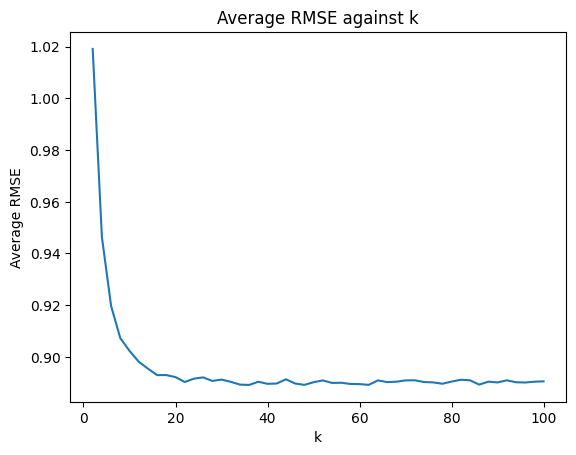

In [12]:
plt.plot(ks,avg_rmse)
plt.title("Average RMSE against k" )
plt.ylabel('Average RMSE')
plt.xlabel('k')
plt.show()

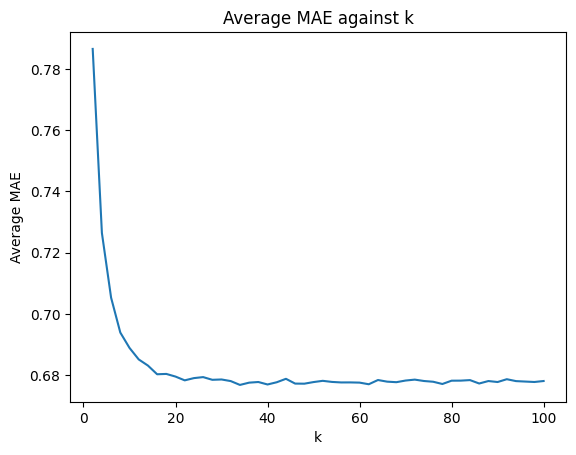

In [13]:
plt.plot(ks,avg_mae)
plt.title("Average MAE against k" )
plt.ylabel('Average MAE')
plt.xlabel('k')
plt.show()

### Question 5

In [14]:
eps = 1e-3
for i in range(len(ks)):
    if((abs(avg_rmse[i]-avg_rmse[i+1])<eps)):
        print(f"Minimum k for RMSE is {ks[i]}, average RMSE is {avg_rmse[i]:.3f}")
        break

for i in range(len(ks)):
    if((abs(avg_mae[i]-avg_mae[i+1])<eps)):
        print(f"Minimum k for MAE is {ks[i]}, average MAE is {avg_mae[i]:.3f}")
        break

Minimum k for RMSE is 16, average RMSE is 0.893
Minimum k for MAE is 16, average MAE is 0.680


### Question 6
### Question 7 is stated on our report

In [77]:
reader = Reader(rating_scale=(0.5, 5))

# data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

data_df = ratings.pivot_table('rating', 'userId', 'movieId')
variance = np.var(data_df, axis=0)

kf = KFold(n_splits=10)

ref = defaultdict(list)
for _, row in ratings.iterrows():
    ref[row['movieId']].append(row['rating'])

In [78]:
def popular_trimming(row):
  return len(ref[row['movieId']]) > 2

def unpopular_trimming(row):
  return len(ref[row['movieId']]) <= 2

def high_variance_trimming(row):
  return len(ref[row['movieId']]) >= 5 and row['movieId'] in variance[variance>=2].keys()

def do_nothing(row):
  return True
  
def minimum_k(title, avg_rmse, avg_mae, ks):
  eps = 1e-3
  best_k = -1
  for i in range(len(ks)-1):
    if((abs(avg_rmse[i]-avg_rmse[i+1])<eps)):
        print(f"{title} Minimum k for RMSE is {ks[i]}, average RMSE is {avg_rmse[i]:.3f}")
        best_k = ks[i]
        break

  for i in range(len(ks)-1):
    if((abs(avg_mae[i]-avg_mae[i+1])<eps)):
        print(f"{title} Minimum k for MAE is {ks[i]}, average MAE is {avg_mae[i]:.3f}")
        break
  return best_k

def plot_k(title, avg_rmse, avg_mae, ks):
    plt.plot(ks,avg_rmse)
    plt.title(f"{title} Average RMSE against k" )
    plt.ylabel('Average RMSE')
    plt.xlabel('k')
    plt.show()

    plt.plot(ks,avg_mae)
    plt.title(f"{title} Average MAE against k" )
    plt.ylabel('Average MAE')
    plt.xlabel('k')
    plt.show()

def report_roc(trainset, testset, best_k, title):
  Threshold_list = [2.5, 3.0, 3.5, 4.0]
  res  = KNNWithMeans(k=best_k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
  
  for thre in Threshold_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > thre:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    labels = f"AUC: {auc(FPR,TPR):.3f} , threshold: {thre}"
    plt.plot(FPR, TPR,lw=2, label=labels)  

  plt.legend(loc='best')
  plt.title(f'{title} ROC of best_k is {best_k}')
  plt.ylabel('True Positive Rate- TPR')
  plt.xlabel('False Positive Rate- FPR')
  plt.show() 

def report_result(ratings, filter, title, ks):
  filter_ratings = ratings[ratings.apply(filter, axis=1)]
  data = Dataset.load_from_df(filter_ratings[['userId','movieId','rating']], reader=reader)

  avg_rmse = []
  avg_mae = []
  rmse_min = 1e3
  rmse_min_k = ks[-1]
  mae_min = 1e3
  mae_min_k = ks[-1]

  for k in ks:
      print(f"k={k}", end=":")
      rmse = 0
      mae = 0
      iter = 1
      for trainset, testset in kf.split(data):
          print(f"iter={iter}", end=",")
          iter += 1
          perf = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
          rmse += accuracy.rmse(perf,verbose=False)
          mae += accuracy.mae(perf,verbose=False)
      print("")
      if rmse < rmse_min:
        rmse_min = rmse
        rmse_min_k = k
      if mae < mae_min:
        mae_min = mae
        mae_min_k = k
      avg_rmse.append(rmse / 10.0)
      avg_mae.append(mae / 10.0)
  
  plot_k(title, avg_rmse, avg_mae,ks)
  best_k = minimum_k(title, avg_rmse, avg_mae,ks)
  if best_k == -1:
    print("no convergence, we just choose a k with min rmse")
    best_k = rmse_min_k
  report_roc(trainset, testset, best_k,title)


k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

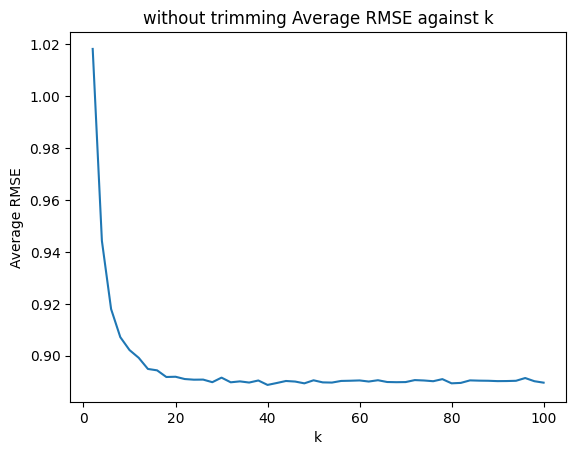

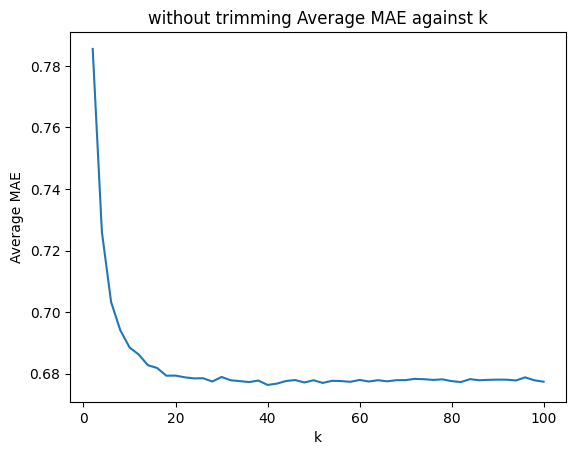

without trimming Minimum k for RMSE is 14, average RMSE is 0.895
without trimming Minimum k for MAE is 14, average MAE is 0.683


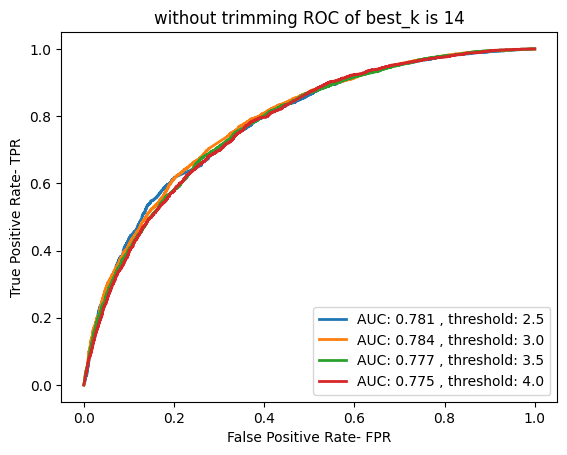

In [79]:
report_result(ratings, do_nothing, "without trimming", ks=np.arange(2,102,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

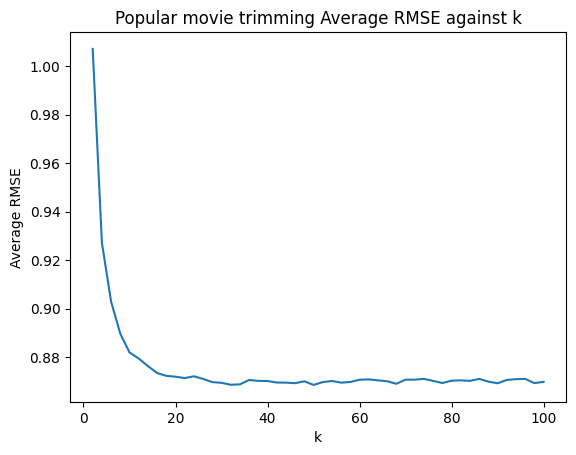

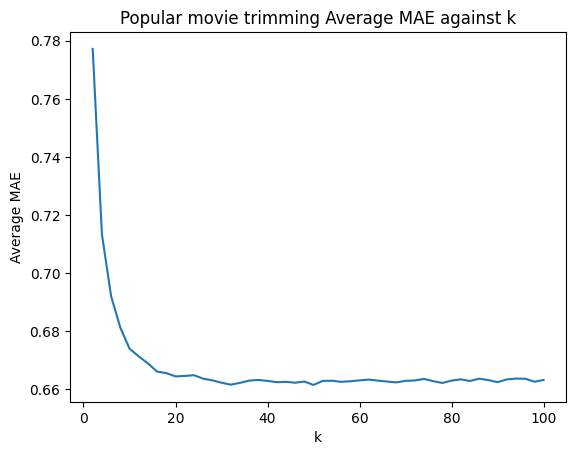

Popular movie trimming Minimum k for RMSE is 18, average RMSE is 0.872
Popular movie trimming Minimum k for MAE is 16, average MAE is 0.666


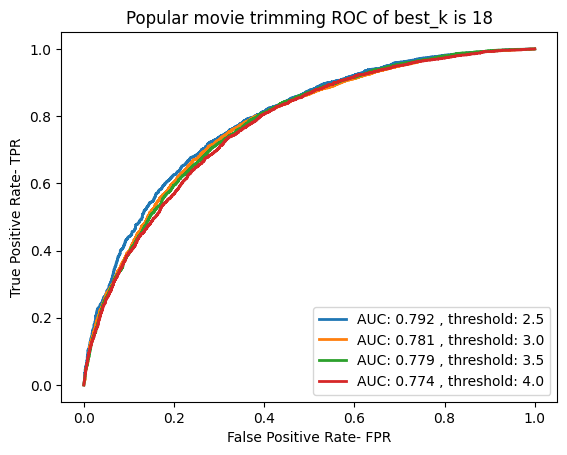

In [80]:
report_result(ratings, popular_trimming, "Popular movie trimming", ks=np.arange(2,102,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

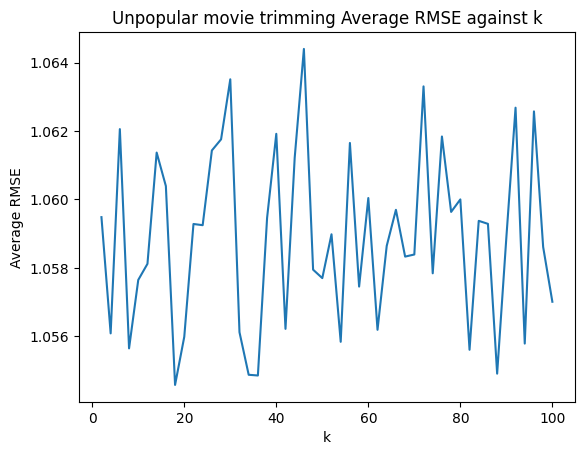

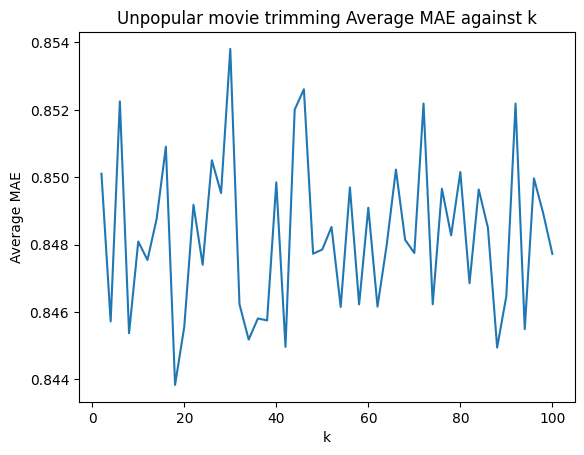

Unpopular movie trimming Minimum k for RMSE is 10, average RMSE is 1.058
Unpopular movie trimming Minimum k for MAE is 10, average MAE is 0.848


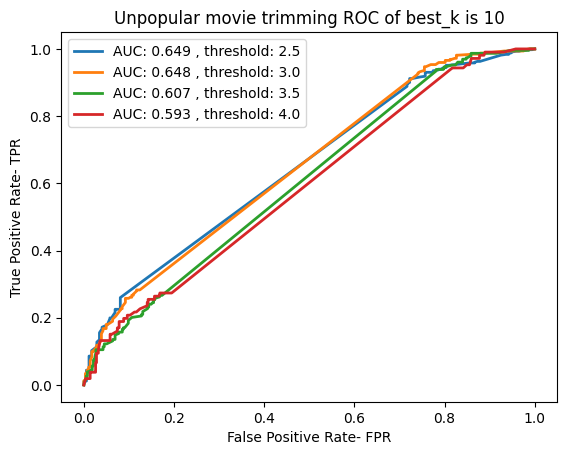

In [81]:
report_result(ratings, unpopular_trimming, "Unpopular movie trimming", ks=np.arange(2,102,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

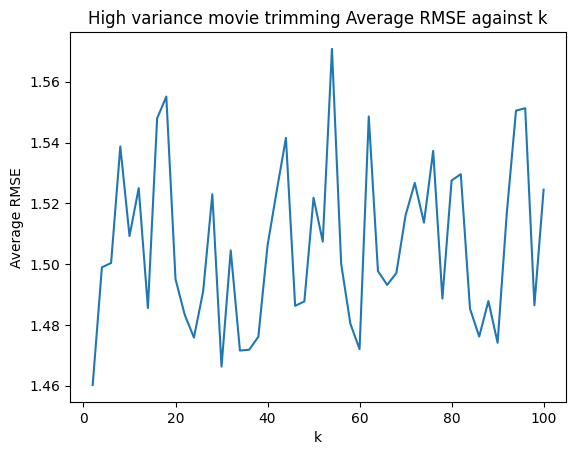

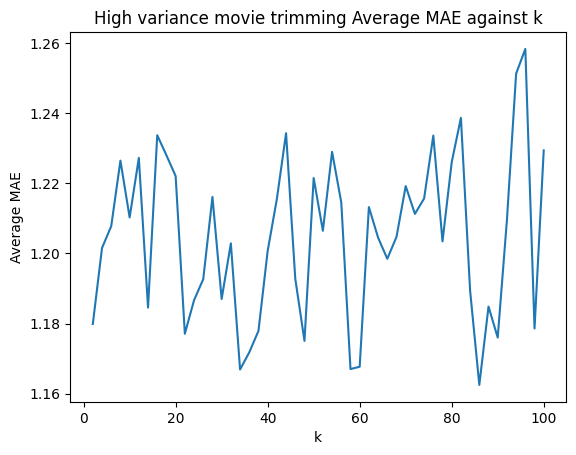

High variance movie trimming Minimum k for RMSE is 34, average RMSE is 1.472
High variance movie trimming Minimum k for MAE is 58, average MAE is 1.167


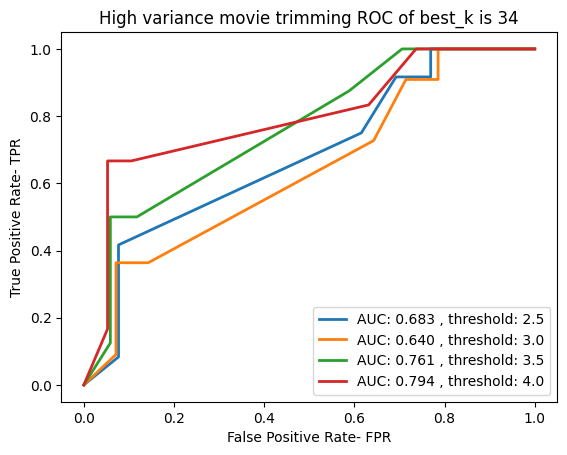

In [102]:
report_result(ratings, high_variance_trimming, "High variance movie trimming", ks=np.arange(2,102,2))

### Question 8

  0%|          | 0/25 [00:00<?, ?it/s]

2


  4%|▍         | 1/25 [00:14<05:50, 14.61s/it]

4


  8%|▊         | 2/25 [00:29<05:37, 14.65s/it]

6


 12%|█▏        | 3/25 [00:44<05:29, 14.97s/it]

8


 16%|█▌        | 4/25 [01:01<05:27, 15.61s/it]

10


 20%|██        | 5/25 [01:21<05:43, 17.20s/it]

12


 24%|██▍       | 6/25 [01:38<05:28, 17.31s/it]

14


 28%|██▊       | 7/25 [02:00<05:35, 18.63s/it]

16


 32%|███▏      | 8/25 [02:18<05:16, 18.63s/it]

18


 36%|███▌      | 9/25 [02:37<04:59, 18.74s/it]

20


 40%|████      | 10/25 [02:57<04:47, 19.14s/it]

22


 44%|████▍     | 11/25 [03:17<04:31, 19.41s/it]

24


 48%|████▊     | 12/25 [03:38<04:18, 19.85s/it]

26


 52%|█████▏    | 13/25 [04:02<04:13, 21.13s/it]

28


 56%|█████▌    | 14/25 [04:24<03:54, 21.35s/it]

30


 60%|██████    | 15/25 [04:46<03:36, 21.62s/it]

32


 64%|██████▍   | 16/25 [05:10<03:19, 22.13s/it]

34


 68%|██████▊   | 17/25 [05:35<03:03, 22.99s/it]

36


 72%|███████▏  | 18/25 [05:59<02:44, 23.51s/it]

38


 76%|███████▌  | 19/25 [06:26<02:26, 24.44s/it]

40


 80%|████████  | 20/25 [06:52<02:04, 24.92s/it]

42


 84%|████████▍ | 21/25 [07:17<01:39, 24.92s/it]

44


 88%|████████▊ | 22/25 [07:42<01:15, 25.04s/it]

46


 92%|█████████▏| 23/25 [08:17<00:55, 27.82s/it]

48


 96%|█████████▌| 24/25 [08:44<00:27, 27.66s/it]

50


100%|██████████| 25/25 [09:17<00:00, 22.30s/it]


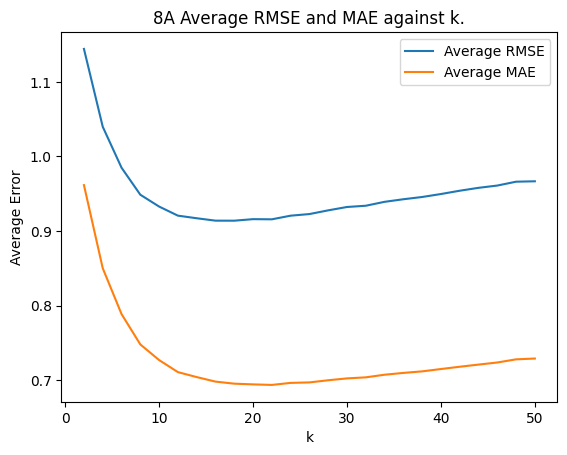

In [4]:
avg_rmse = []
avg_mae = []

min_rmse = 1e4
min_mae = 1e4
min_rmse_k = 0
min_rmsse_k = 0

new_ks = np.arange(2,52,2) 
for i in trange(len(new_ks)):
  k = new_ks[i]
  print(k)
  nmf = NMF(n_factors = k)
  cv_ = cross_validate(nmf, data, measures=['rmse', 'mae'], cv=10, verbose=False)

  rmse = np.mean(cv_["test_rmse"])
  avg_rmse.append(rmse)
  if rmse < min_rmse:
    min_rmse = rmse
    min_rmse_k = k
  
  mae = np.mean(cv_["test_mae"])
  avg_mae.append(mae)
  if mae < min_mae:
    min_mae = mae
    min_mae_k = k

plt.plot(new_ks, avg_rmse, label="Average RMSE")
plt.plot(new_ks, avg_mae, label="Average MAE")
plt.title("8A NMF Average RMSE and MAE against k.")
plt.legend()
plt.xlabel("k")
plt.ylabel("Average Error")
plt.show()

In [5]:
print("Question8B")
print(f"Minimum Average RMSE (NMF) = {min_rmse:.3f}, k = {min_rmse_k}")
print(f"Minimum Average MAE (NMF) = {min_mae:.3f}, k = {min_mae_k}")

Question8B
Minimum Average RMSE (NMF) = 0.914, k = 18
Minimum Average MAE (NMF) = 0.694, k = 22


In [84]:
def report_roc_nmf(trainset, testset, best_k, title):
  Threshold_list = [2.5, 3.0, 3.5, 4.0]
  res  = NMF(n_factors=best_k,n_epochs=30,verbose=False).fit(trainset).test(testset)
  
  for thre in Threshold_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > thre:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    labels = f"AUC: {auc(FPR,TPR):.3f} , threshold: {thre}"
    plt.plot(FPR, TPR,lw=2, label=labels)  

  plt.legend(loc='best')
  plt.title(f'{title} ROC of best_k is {best_k}')
  plt.ylabel('True Positive Rate- TPR')
  plt.xlabel('False Positive Rate- FPR')
  plt.show() 

def report_result_nmf(ratings, filter, title, ks):
  filter_ratings = ratings[ratings.apply(filter, axis=1)]
  data = Dataset.load_from_df(filter_ratings[['userId','movieId','rating']], reader=reader)

  avg_rmse = []
  avg_mae = []
  rmse_min = 1e3
  rmse_min_k = ks[-1]
  mae_min = 1e3
  mae_min_k = ks[-1]

  for k in ks:
      print(f"k={k}", end=":")
      rmse = 0
      mae = 0
      iter = 1
      for trainset, testset in kf.split(data):
          print(f"iter={iter}", end=",")
          iter += 1
          perf = NMF(n_factors=k,n_epochs=30,verbose=False).fit(trainset).test(testset)
          rmse += accuracy.rmse(perf,verbose=False)
          mae += accuracy.mae(perf,verbose=False)
      print("")
      if rmse < rmse_min:
        rmse_min = rmse
        rmse_min_k = k
      if mae < mae_min:
        mae_min = mae
        mae_min_k = k
      avg_rmse.append(rmse / 10.0)
      avg_mae.append(mae / 10.0)
  
  plot_k(title, avg_rmse, avg_mae,ks)
  best_k = minimum_k(title, avg_rmse, avg_mae,ks)
  if best_k == -1:
    print("no convergence, we just choose a k with min rmse")
    best_k = rmse_min_k
  report_roc_nmf(trainset, testset, best_k,title)

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

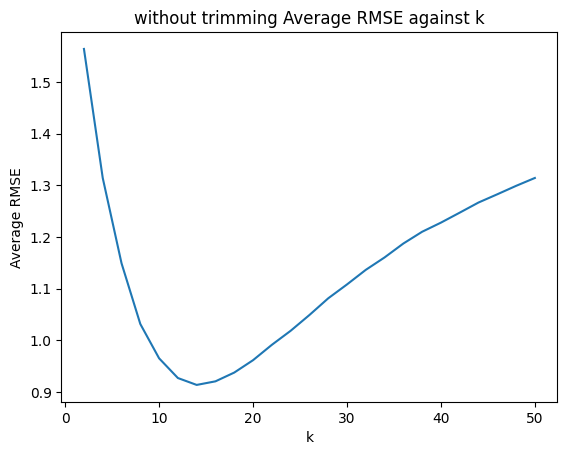

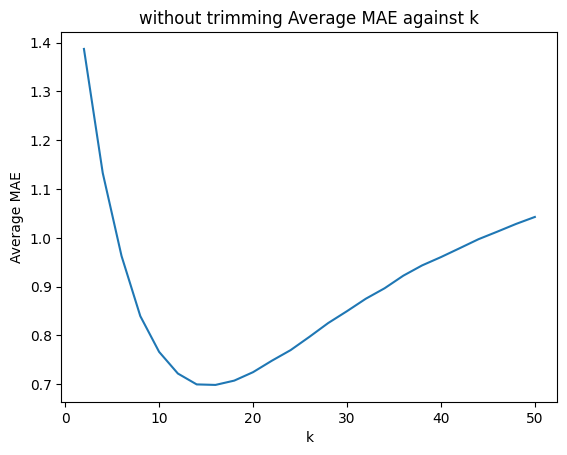

no convergence, we just choose a k with min rmse


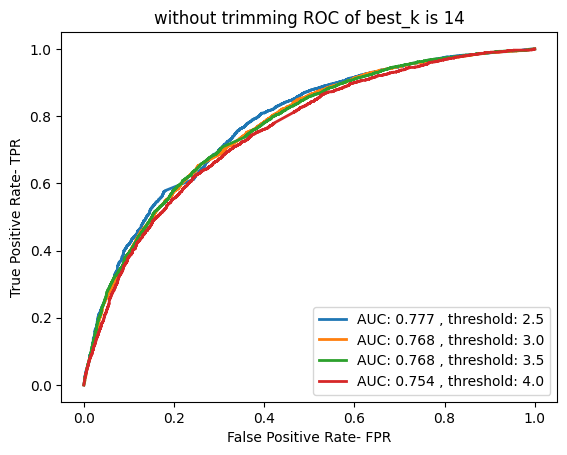

In [85]:
report_result_nmf(ratings, do_nothing, "without trimming", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

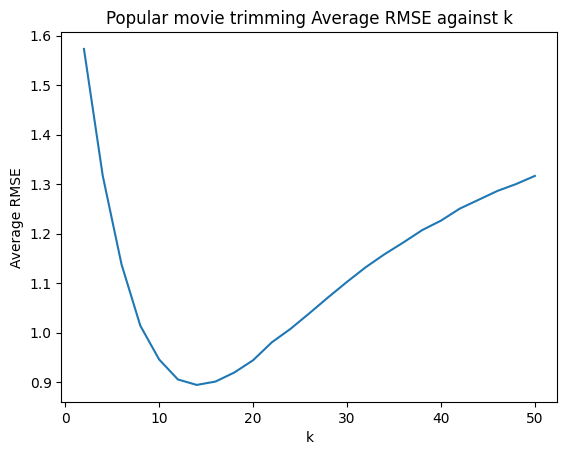

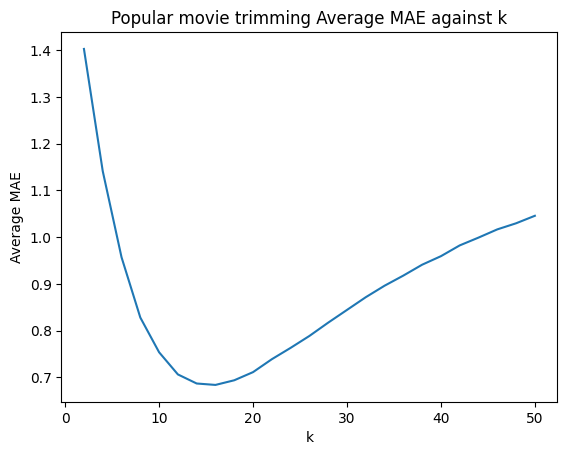

no convergence, we just choose a k with min rmse


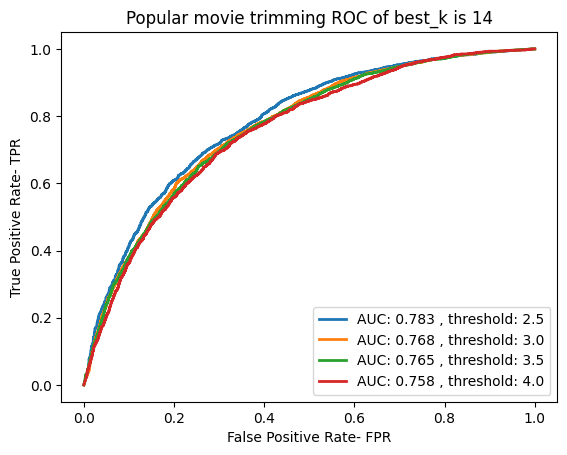

In [86]:
report_result_nmf(ratings, popular_trimming, "Popular movie trimming", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

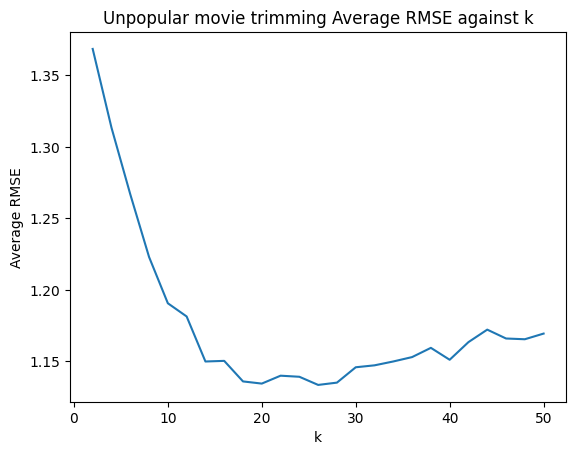

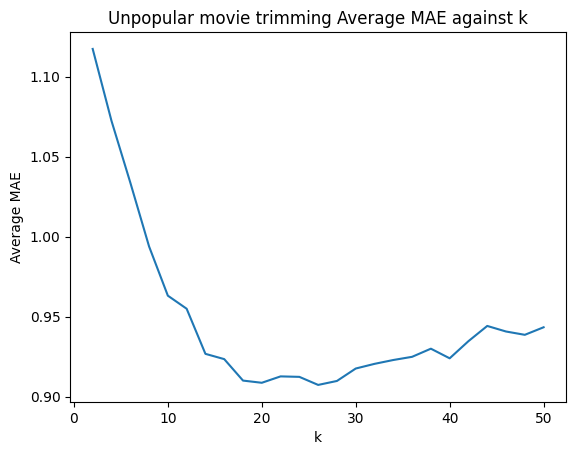

Unpopular movie trimming Minimum k for RMSE is 14, average RMSE is 1.150
Unpopular movie trimming Minimum k for MAE is 22, average MAE is 0.913


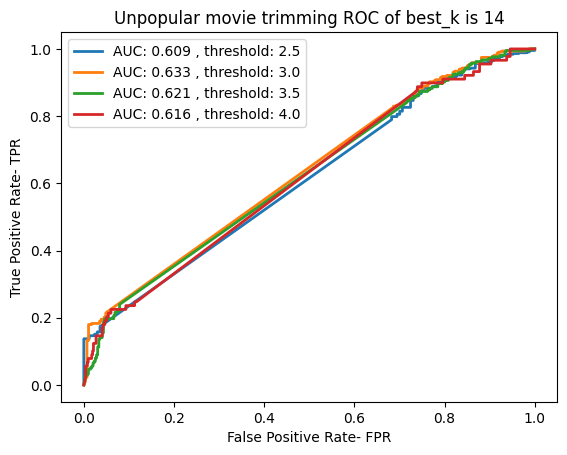

In [87]:
report_result_nmf(ratings, unpopular_trimming, "Unpopular movie trimming", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

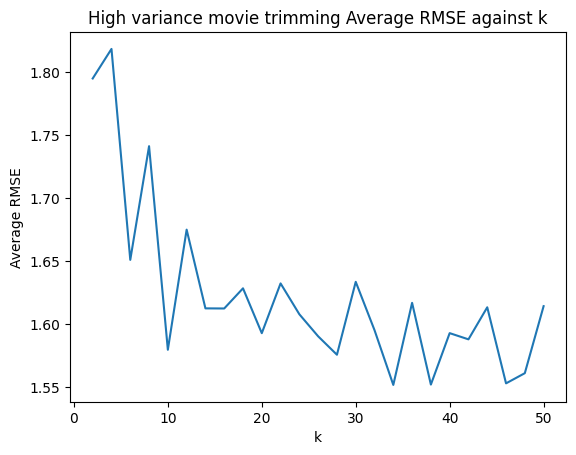

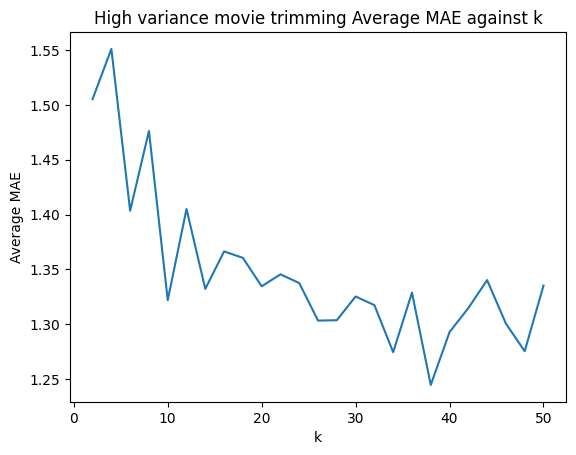

High variance movie trimming Minimum k for RMSE is 14, average RMSE is 1.612
High variance movie trimming Minimum k for MAE is 26, average MAE is 1.303


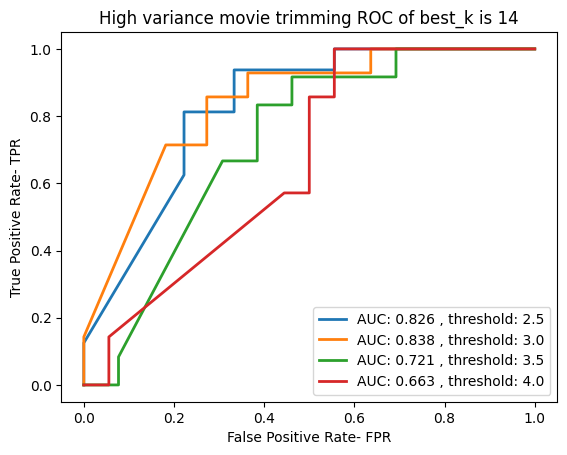

In [97]:
report_result_nmf(ratings, high_variance_trimming, "High variance movie trimming", ks=np.arange(2,52,2))

### Question 9

In [11]:
nmf_k20 = NMF(n_factors=20,n_epochs=30,verbose=False)
nmf_k20.fit(trainset).test(testset)

U_mat = nmf_k20.pu
V_mat = nmf_k20.qi

def interpret_latent_factor(num_latent_factors, V_mat):
    for i in range(num_latent_factors):
        movie_ids = np.argsort(-V_mat[:,i])[0:10]
        print(f"Latent Factor {i}")
        val = V_mat[movie_ids, i]
        for j in range(10):
          genre = movies.iloc[movie_ids[j]]['genres']
          print(f"Genre: {genre} Value: {val[j]:.4f}")

In [12]:
interpret_latent_factor(20, V_mat)

Latent Factor 0
Genre: Adventure|Drama Value: 2.1386
Genre: Comedy|Fantasy|Horror|Thriller Value: 1.9934
Genre: Action|Crime|Drama Value: 1.8720
Genre: Comedy|Crime|Drama Value: 1.8599
Genre: Comedy|Drama|Romance Value: 1.8268
Genre: Crime|Mystery Value: 1.7254
Genre: Horror|Thriller Value: 1.6945
Genre: Drama|Mystery|Thriller Value: 1.6634
Genre: Action|Thriller Value: 1.6603
Genre: Comedy|Romance Value: 1.6455
Latent Factor 1
Genre: Comedy Value: 2.1365
Genre: Action|Adventure|Animation|Fantasy|Sci-Fi Value: 2.0220
Genre: Comedy Value: 1.7544
Genre: Adventure|Animation|Children Value: 1.7514
Genre: Action|Animation|Children|Crime Value: 1.6294
Genre: Action|Adventure|Sci-Fi|Thriller Value: 1.6181
Genre: Comedy Value: 1.6069
Genre: Drama Value: 1.5759
Genre: Comedy Value: 1.5555
Genre: Drama Value: 1.5539
Latent Factor 2
Genre: Crime|Film-Noir Value: 2.0518
Genre: Drama|Thriller Value: 1.9304
Genre: Drama Value: 1.7626
Genre: Action|Crime|Drama Value: 1.7527
Genre: Action|Crime|Thrill

### Question 10

  0%|          | 0/25 [00:00<?, ?it/s]

2


  4%|▍         | 1/25 [00:06<02:40,  6.69s/it]

4


  8%|▊         | 2/25 [00:14<02:45,  7.19s/it]

6


 12%|█▏        | 3/25 [00:22<02:48,  7.65s/it]

8


 16%|█▌        | 4/25 [00:30<02:45,  7.88s/it]

10


 20%|██        | 5/25 [00:39<02:41,  8.07s/it]

12


 24%|██▍       | 6/25 [00:47<02:36,  8.22s/it]

14


 28%|██▊       | 7/25 [00:56<02:30,  8.36s/it]

16


 32%|███▏      | 8/25 [01:04<02:23,  8.46s/it]

18


 36%|███▌      | 9/25 [01:13<02:17,  8.60s/it]

20


 40%|████      | 10/25 [01:23<02:11,  8.79s/it]

22


 44%|████▍     | 11/25 [01:37<02:28, 10.62s/it]

24


 48%|████▊     | 12/25 [01:55<02:44, 12.66s/it]

26


 52%|█████▏    | 13/25 [02:12<02:48, 14.08s/it]

28


 56%|█████▌    | 14/25 [02:21<02:16, 12.45s/it]

30


 60%|██████    | 15/25 [02:28<01:50, 11.06s/it]

32


 64%|██████▍   | 16/25 [02:40<01:40, 11.18s/it]

34


 68%|██████▊   | 17/25 [02:49<01:24, 10.55s/it]

36


 72%|███████▏  | 18/25 [02:58<01:10, 10.13s/it]

38


 76%|███████▌  | 19/25 [03:06<00:56,  9.48s/it]

40


 80%|████████  | 20/25 [03:15<00:46,  9.22s/it]

42


 84%|████████▍ | 21/25 [03:23<00:35,  8.94s/it]

44


 88%|████████▊ | 22/25 [03:32<00:26,  8.88s/it]

46


 92%|█████████▏| 23/25 [03:41<00:18,  9.12s/it]

48


 96%|█████████▌| 24/25 [03:51<00:09,  9.19s/it]

50


100%|██████████| 25/25 [04:03<00:00,  9.74s/it]


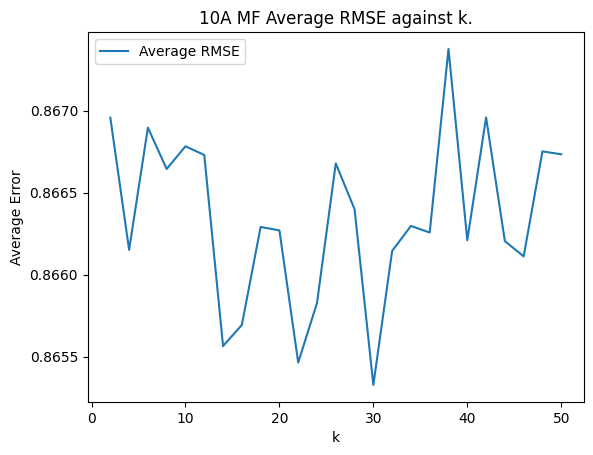

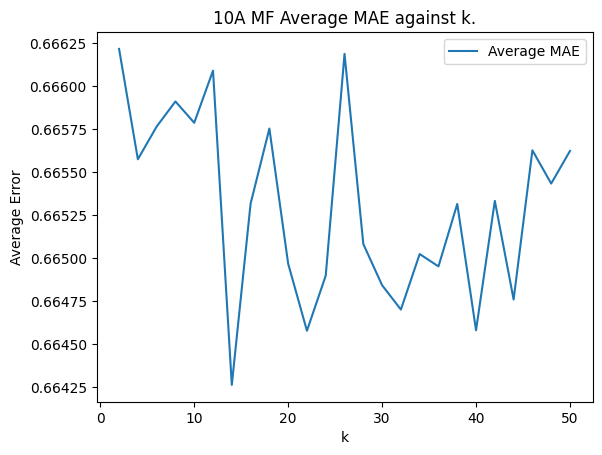

In [5]:
avg_rmse = []
avg_mae = []

min_rmse = 1e4
min_mae = 1e4
min_rmse_k = 0
min_rmsse_k = 0

new_ks = np.arange(2,52,2) 
for i in trange(len(new_ks)):
  k = new_ks[i]
  print(k)
  svd = SVD(n_factors = k)
  cv_ = cross_validate(svd, data, measures=['rmse', 'mae'], cv=10, verbose=False)

  rmse = np.mean(cv_["test_rmse"])
  avg_rmse.append(rmse)
  if rmse < min_rmse:
    min_rmse = rmse
    min_rmse_k = k
  
  mae = np.mean(cv_["test_mae"])
  avg_mae.append(mae)
  if mae < min_mae:
    min_mae = mae
    min_mae_k = k

plt.plot(new_ks, avg_rmse, label="Average RMSE")
plt.title("10A MF Average RMSE against k.")
plt.legend()
plt.xlabel("k")
plt.ylabel("Average Error")
plt.show()

plt.plot(new_ks, avg_mae, label="Average MAE")
plt.title("10A MF Average MAE against k.")
plt.legend()
plt.xlabel("k")
plt.ylabel("Average Error")
plt.show()

In [8]:
print("Question10B")
print(f"Minimum Average RMSE (SVD) = {min_rmse:.3f}, k = {min_rmse_k}")
print(f"Minimum Average MAE (SVD) = {min_mae:.3f}, k = {min_mae_k}")

Question10B  
  Minimum Average RMSE (SVD) = 0.865, k = 24  
  Minimum Average MAE (SVD) = 0.664, k = 24


In [90]:
def report_roc_svd(trainset, testset, best_k, title):
  Threshold_list = [2.5, 3.0, 3.5, 4.0]
  res  = SVD(n_factors=best_k,n_epochs=30,verbose=False).fit(trainset).test(testset)
  
  for thre in Threshold_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > thre:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    labels = f"AUC: {auc(FPR,TPR):.3f} , threshold: {thre}"
    plt.plot(FPR, TPR,lw=2, label=labels)  

  plt.legend(loc='best')
  plt.title(f'{title} ROC of best_k is {best_k}')
  plt.ylabel('True Positive Rate- TPR')
  plt.xlabel('False Positive Rate- FPR')
  plt.show() 

def report_result_svd(ratings, filter, title, ks):
  filter_ratings = ratings[ratings.apply(filter, axis=1)]
  data = Dataset.load_from_df(filter_ratings[['userId','movieId','rating']], reader=reader)

  avg_rmse = []
  avg_mae = []
  rmse_min = 1e3
  rmse_min_k = ks[-1]
  mae_min = 1e3
  mae_min_k = ks[-1]

  for k in ks:
      print(f"k={k}", end=":")
      rmse = 0
      mae = 0
      iter = 1
      for trainset, testset in kf.split(data):
          print(f"iter={iter}", end=",")
          iter += 1
          perf = SVD(n_factors=k,n_epochs=30,verbose=False).fit(trainset).test(testset)
          rmse += accuracy.rmse(perf,verbose=False)
          mae += accuracy.mae(perf,verbose=False)
      print("")
      if rmse < rmse_min:
        rmse_min = rmse
        rmse_min_k = k
      if mae < mae_min:
        mae_min = mae
        mae_min_k = k
      avg_rmse.append(rmse / 10.0)
      avg_mae.append(mae / 10.0)
  
  plot_k(title, avg_rmse, avg_mae,ks)
  best_k = minimum_k(title, avg_rmse, avg_mae,ks)
  if best_k == -1:
    print("no convergence, we just choose a k with min rmse")
    best_k = rmse_min_k
  report_roc_nmf(trainset, testset, best_k,title)


k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

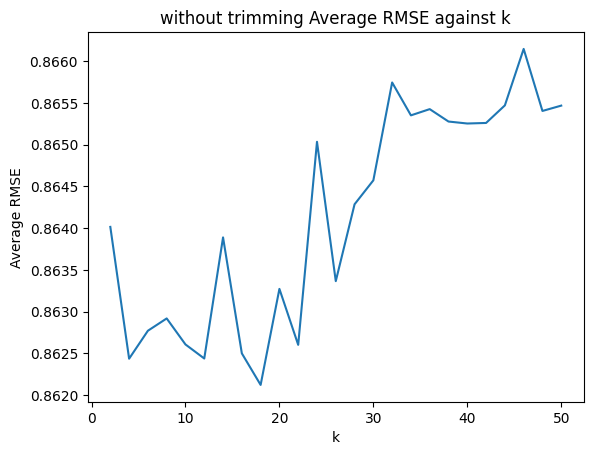

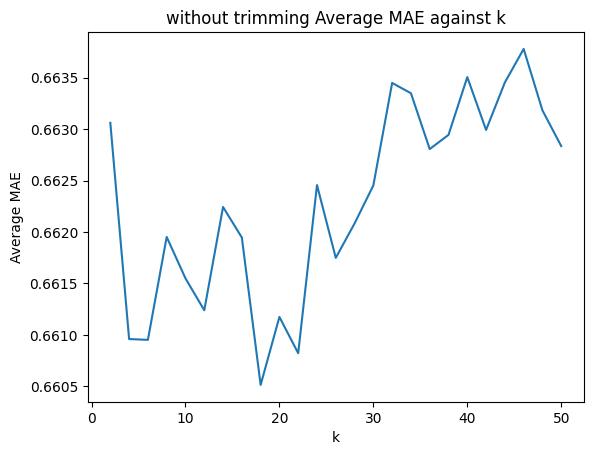

without trimming Minimum k for RMSE is 4, average RMSE is 0.862
without trimming Minimum k for MAE is 4, average MAE is 0.661


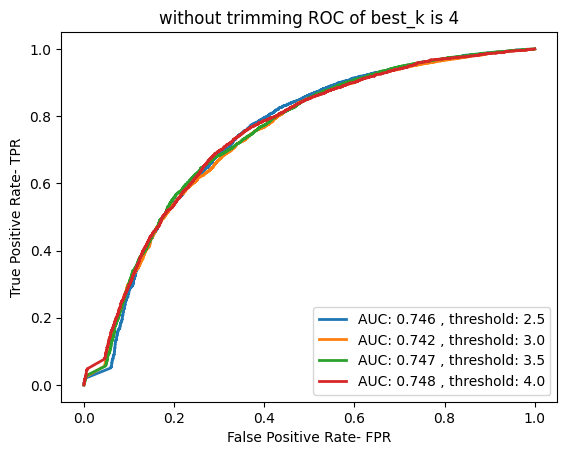

In [91]:
report_result_svd(ratings, do_nothing, "without trimming", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

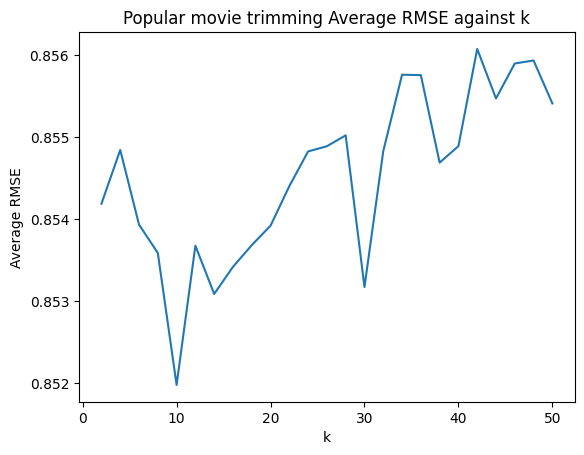

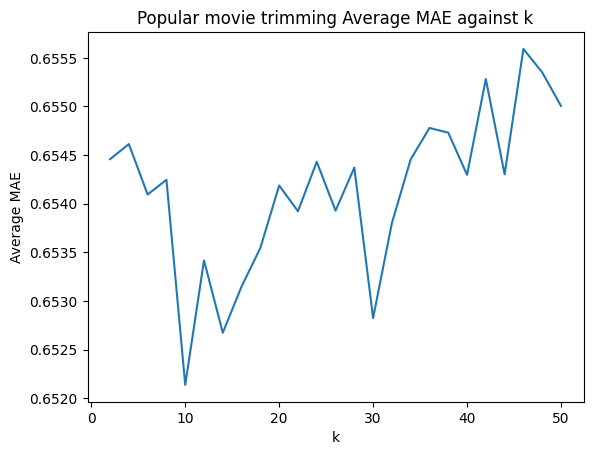

Popular movie trimming Minimum k for RMSE is 2, average RMSE is 0.854
Popular movie trimming Minimum k for MAE is 2, average MAE is 0.654


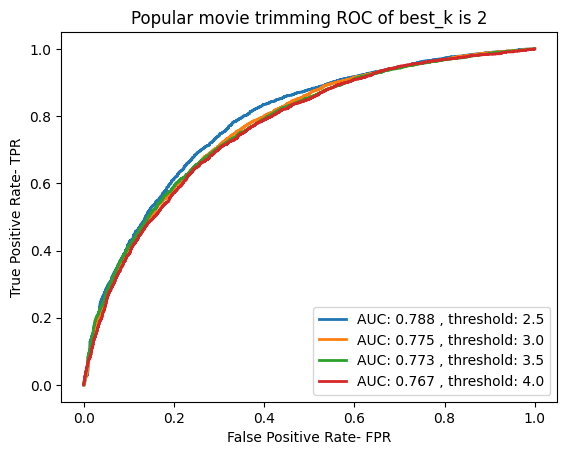

In [92]:
report_result_svd(ratings, popular_trimming, "Popular movie trimming", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

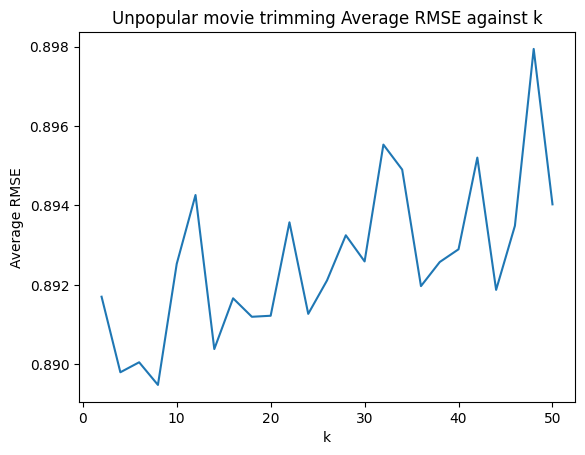

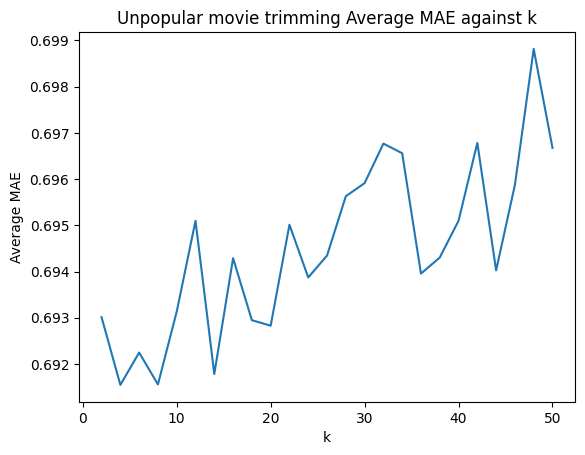

Unpopular movie trimming Minimum k for RMSE is 4, average RMSE is 0.890
Unpopular movie trimming Minimum k for MAE is 4, average MAE is 0.692


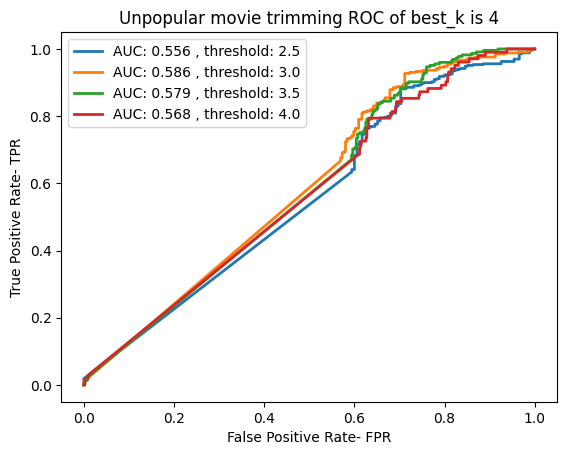

In [93]:
report_result_svd(ratings, unpopular_trimming, "Unpopular movie trimming", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

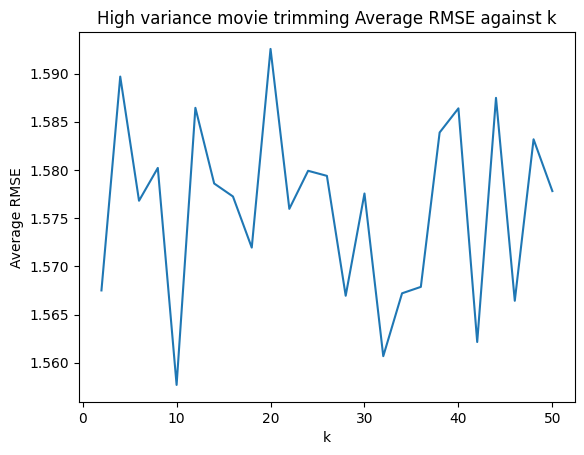

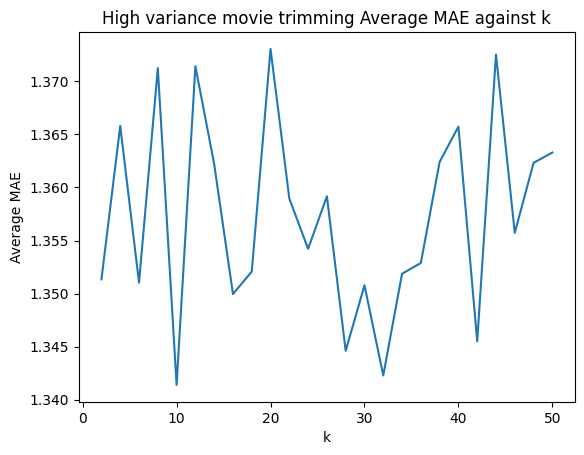

High variance movie trimming Minimum k for RMSE is 24, average RMSE is 1.580
High variance movie trimming Minimum k for MAE is 48, average MAE is 1.362


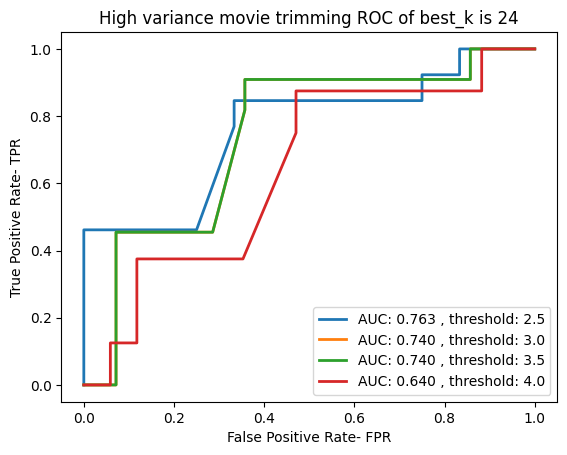

In [104]:
report_result_svd(ratings, high_variance_trimming, "High variance movie trimming", ks=np.arange(2,52,2))

### Question 11

In [22]:
users_ratings = defaultdict(list)
for d in data.raw_ratings:
  user_id, movie_id, rating, _ = d
  users_ratings[user_id].append(rating)

users_mean_ratings = defaultdict(list)
for user_id in users_ratings.keys():
  users_mean_ratings[user_id] = np.mean(users_ratings[user_id])

kf = KFold(n_splits=10)
rmse_naive = 0

for trainset, testset in kf.split(data):
    pred = [users_mean_ratings[i[0]] for i in testset]
    true = [i[2] for i in testset]
    rmse_naive += np.sqrt(mean_squared_error(true, pred))

avg_rmse_naive = rmse_naive / 10.0

print(f"avg_rmse_naive = {avg_rmse_naive:.3f}")

avg_rmse_naive = 0.935


In [25]:
def report_result_naive(function,title):
    rmse_naive = 0
    for trainset, testset in kf.split(data):
        trim = function(testset)
        pred = [users_mean_ratings[i[0]] for i in trim]
        true = [i[2] for i in trim]
        rmse_naive += np.sqrt(mean_squared_error(true, pred))
    avg_rmse_naive = rmse_naive / 10.0
    print(f"naive collaborative filter {title} avg_rmse_naive = {avg_rmse_naive:.3f}")

In [29]:
report_result_naive(popular_trimming, "Popular movie trimming")

naive collaborative filter Popular movie trimming avg_rmse_naive = 0.932


In [28]:
report_result_naive(unpopular_trimming, "Unpopular movie trimming")

naive collaborative filter Unpopular movie trimming avg_rmse_naive = 0.971


In [27]:
report_result_naive(high_variance_trimming, "High variance movie trimming")

naive collaborative filter High variance movie trimming avg_rmse_naive = 1.455


### Question 12

In [ ]:
# KNN BEST_K = 14
KNNMeans_best = KNNWithMeans(k=14,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
# NMF BEST_K = 14
NMF_best  = NMF(n_factors=14,n_epochs=30,verbose=False).fit(trainset).test(testset)
# MF BEST_K = 4
MF_best  = SVD(n_factors=4,n_epochs=30,verbose=False).fit(trainset).test(testset)

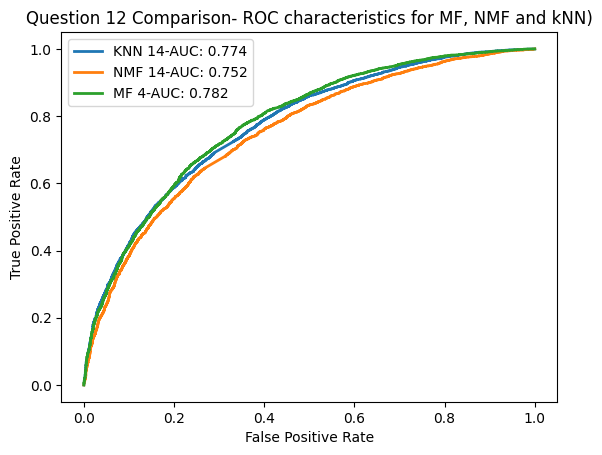

In [9]:
def plot_(result,title):
    threshold_result = []
    for row in result:
        if row.r_ui > 3:
            threshold_result.append(1)
        else:
            threshold_result.append(0)
    fpr, tpr, thresholds = roc_curve(threshold_result, [row.est for row in result])
    labels = f"{title}-AUC: {auc(fpr,tpr):.3f}"
    plt.plot(fpr, tpr,lw=2, label=labels)  

plot_(KNNMeans_best, "KNN 14")
plot_(NMF_best, "NMF 14")
plot_(MF_best, "MF 4")

plt.legend(loc='best')
plt.title('Question 12 Comparison- ROC characteristics for MF, NMF and kNN)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Question 13 is stated on our report
### Question 14

In [108]:
K = np.arange(1,26,1)
k_fold = KFold(n_splits=10)

dict_above_3 = defaultdict(list)
dict_of_all = defaultdict(list)

for _, row in ratings.iterrows():
    if row['rating'] >= 3.0:
        dict_above_3[row['userId']].append(row['movieId'])
    dict_of_all[row['userId']].append(row['movieId'])

def filter_(row,k):
  return len(dict_of_all[row['userId']]) >= k and len(dict_above_3[row['userId']]) > 0

def plot_precision_recall(function,pre,rec):
    plt.plot(K,pre)
    plt.title(f'{function}- Precision versus t')
    plt.ylabel(f'Average Precision-{function}')
    plt.xlabel('t')
    plt.show()

    plt.plot(K,rec)
    plt.title(f'{function}- Recall versus t')
    plt.ylabel(f'Average Recall-{function}')
    plt.xlabel('t')
    plt.show()

    plt.plot(rec, pre)
    plt.title(f'{function}- Precision versus Recall')
    plt.ylabel('Average precision')
    plt.xlabel('Average recall')
    plt.show()

def calculate_precision_recall(ratings, function):
    precision_= []
    recall_ = []
    
    for k in K:
        print(f"k={k}", end=":")
        iter = 1
        precision_k = []
        recall_k = []
        fuc_ = lambda x: filter_(x, k)  
        filter_ratings = ratings[ratings.apply(fuc_, axis=1)]
        data = Dataset.load_from_df(filter_ratings[['userId','movieId','rating']], reader=reader)
        for trainset, testset in kf.split(data):
            print(f"iter={iter}", end=",")
            iter += 1
            if function == "KNN":
                res = KNNWithMeans(k=14,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
            if function == "NMF":
                res = NMF(n_factors=14,n_epochs=30,verbose=False).fit(trainset).test(testset)
            if function == "MF":
                res = SVD(n_factors=4,n_epochs=30,verbose=False).fit(trainset).test(testset)

            pred_ratings = defaultdict(list)

            for row in res:
                pred_ratings[row[0]].append((row[1],row[3]))
                
            precision_u = []
            recall_u = []
            for key in pred_ratings.keys():

                Set_all = sorted(pred_ratings[key],key=lambda x:x[1],reverse=True)
                Set_K = set([row[0] for row in Set_all[0:k]])

                precision_u.append(len(Set_K.intersection(dict_above_3[key]))/float(len(Set_K)))
                recall_u.append(len(Set_K.intersection(dict_above_3[key]))/float(len(dict_above_3[key])))

            precision_k.append(np.mean(precision_u))
            recall_k.append(np.mean(recall_u))
        print("")
        precision_.append(np.mean(precision_k))
        recall_.append(np.mean(recall_k))
    plot_precision_recall(function, precision_, recall_)
    return precision_, recall_

k=1:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=3:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=5:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=7:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=9:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=11:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=13:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:ite

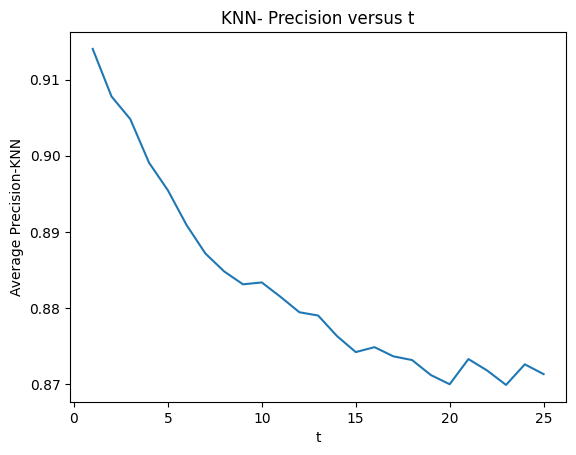

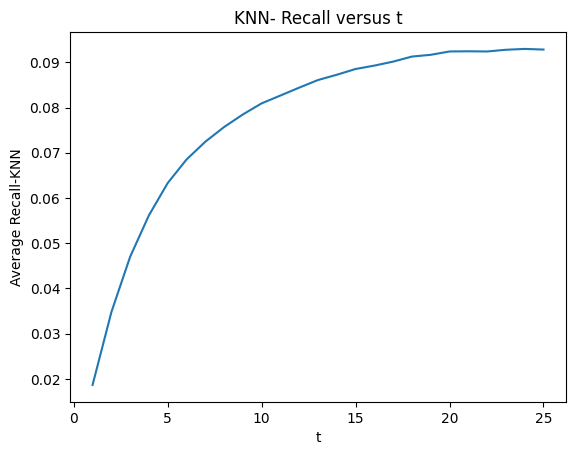

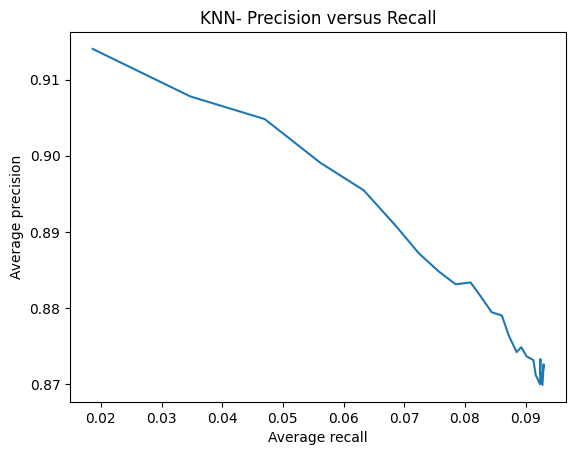

In [109]:
pre_knn, rec_knn = calculate_precision_recall(ratings, "KNN")

k=1:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=3:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=5:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=7:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=9:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=11:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=13:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:ite

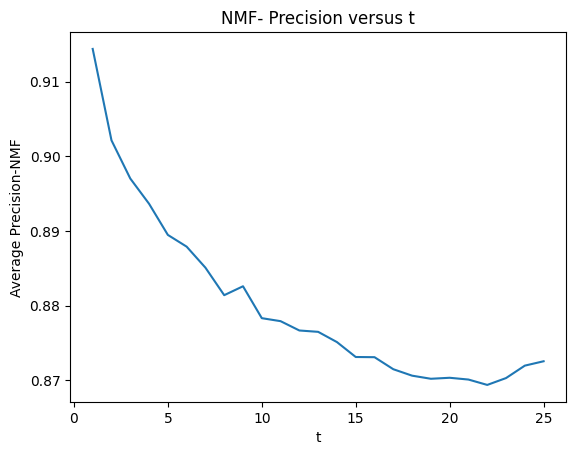

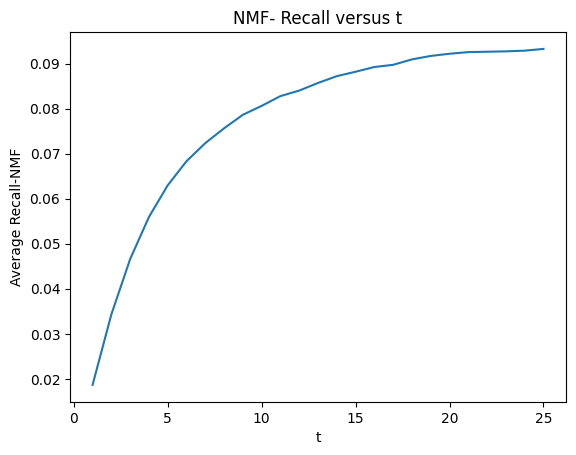

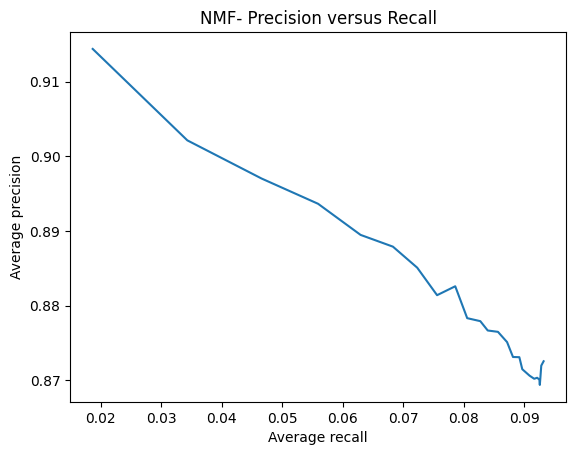

In [110]:
pre_nmf, rec_nmf = calculate_precision_recall(ratings, "NMF")

k=1:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=3:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=5:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=7:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=9:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=11:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=13:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:ite

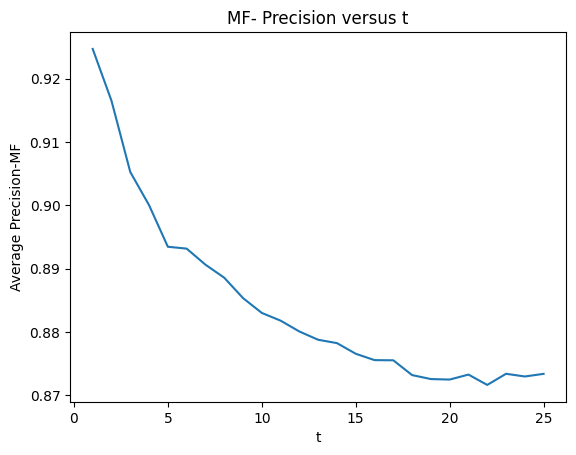

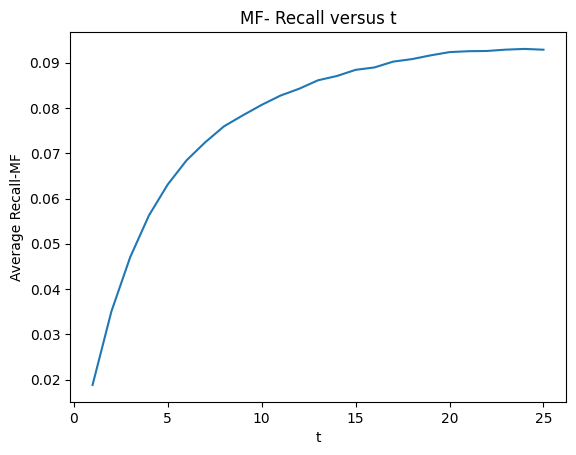

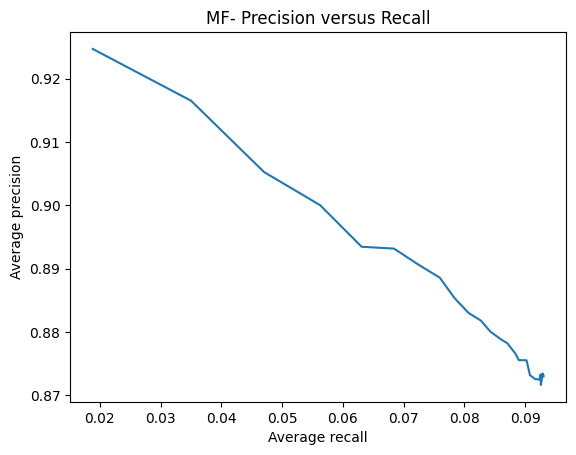

In [111]:
pre_mf, rec_mf = calculate_precision_recall(ratings, "MF")

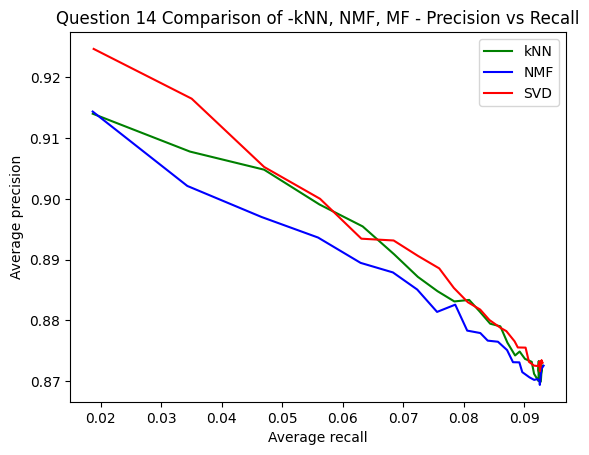

In [112]:
plt.plot(rec_knn, pre_knn,color='g',label='kNN')
plt.plot(rec_nmf, pre_nmf,color='b',label='NMF')
plt.plot(rec_mf, pre_mf,color='r',label='SVD')

plt.title('Question 14 Comparison of -kNN, NMF, MF - Precision vs Recall')
plt.ylabel('Average precision')
plt.xlabel('Average recall')
plt.legend(loc="best")
plt.show()